# Steering vectors 101: NLP deep dive

## Exercise Set #1
Go to your favourite AI chat system as try these two prompts
1. Help me write a 100 word review of the movie Titanic.
1. Help me wrtie a 100 word positive review of the movie Titanic.
2. Help me wrtie a 100 word negative review of the movie Titanic.

**What do we notice?**

Well with Chatgpt I noticed that the promt without any explicit postive or negative nudding for leaning towards positive, however when explicitly asked for a negative review it coherently generated one.


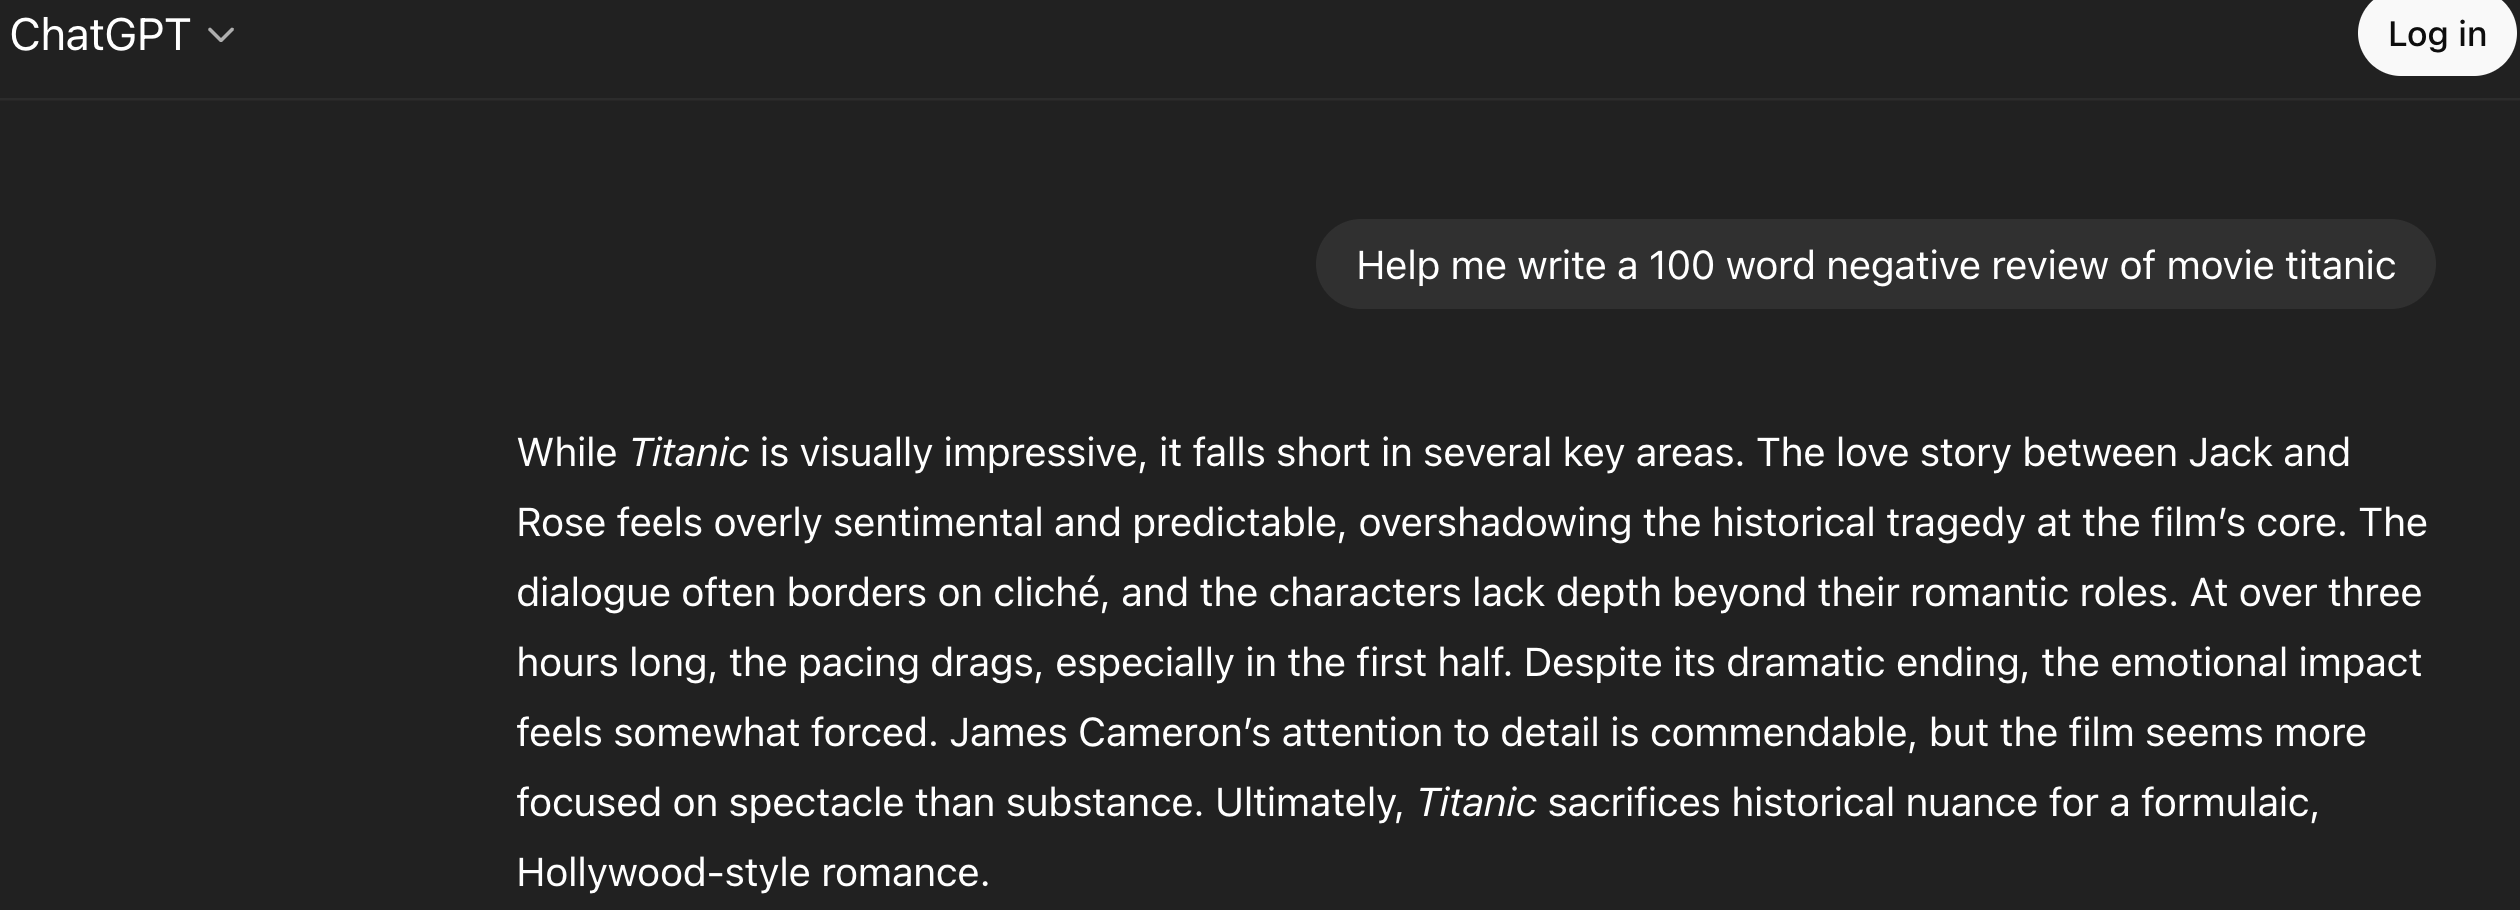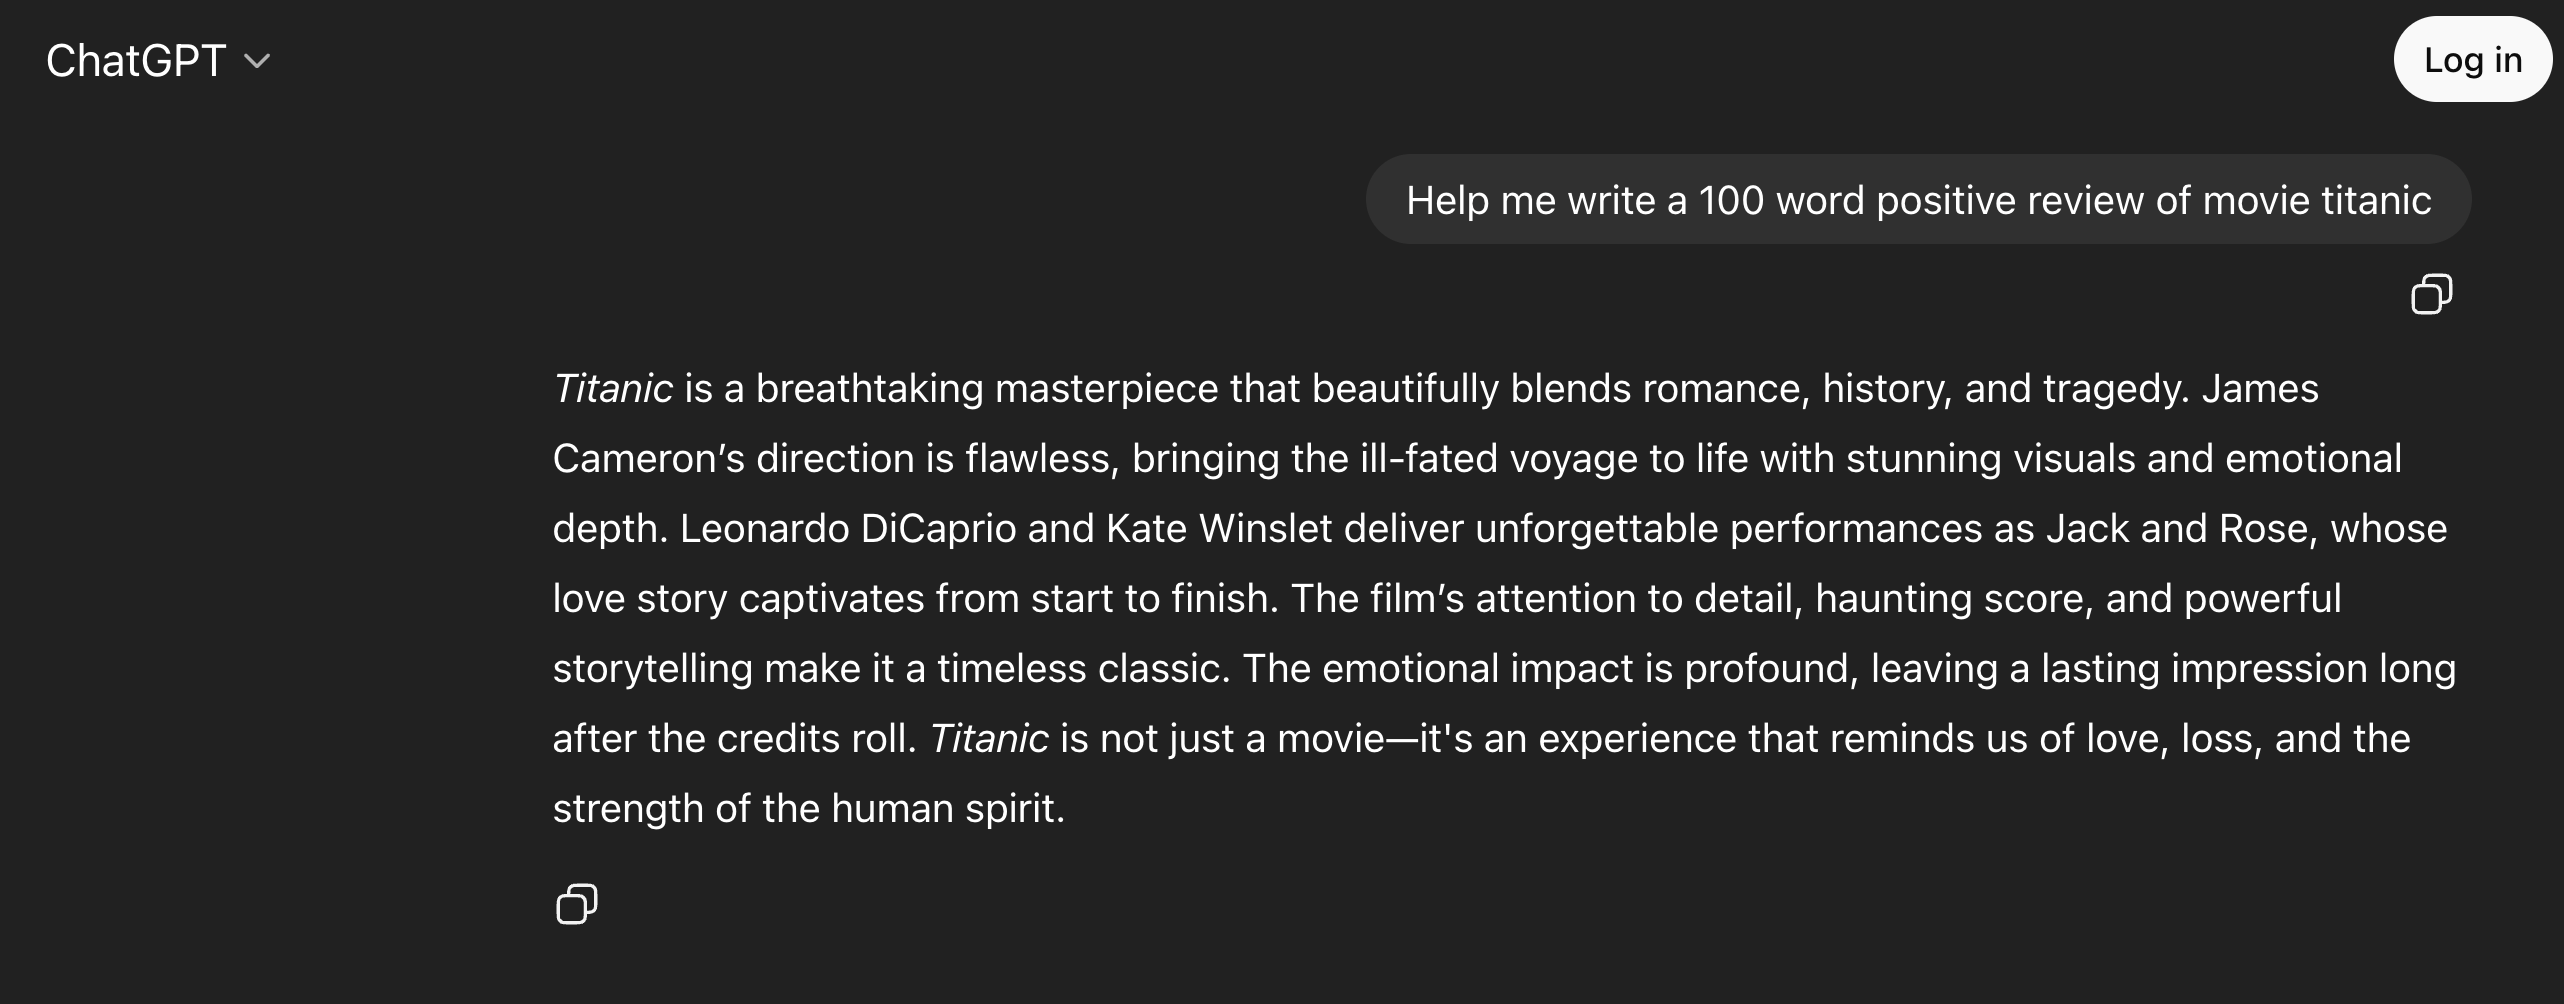

**This is also a form of Steering!**

## Understanding the behind the scene

**What if you want to develop a chatbot that only generates positive reviews** so that even when users ask for a negative one, the output gets nudged towards the positive text.

Let us think of it in terms of 1-D vector where the range of positive steering ranges from 0+4 and that of negative from 0-3.

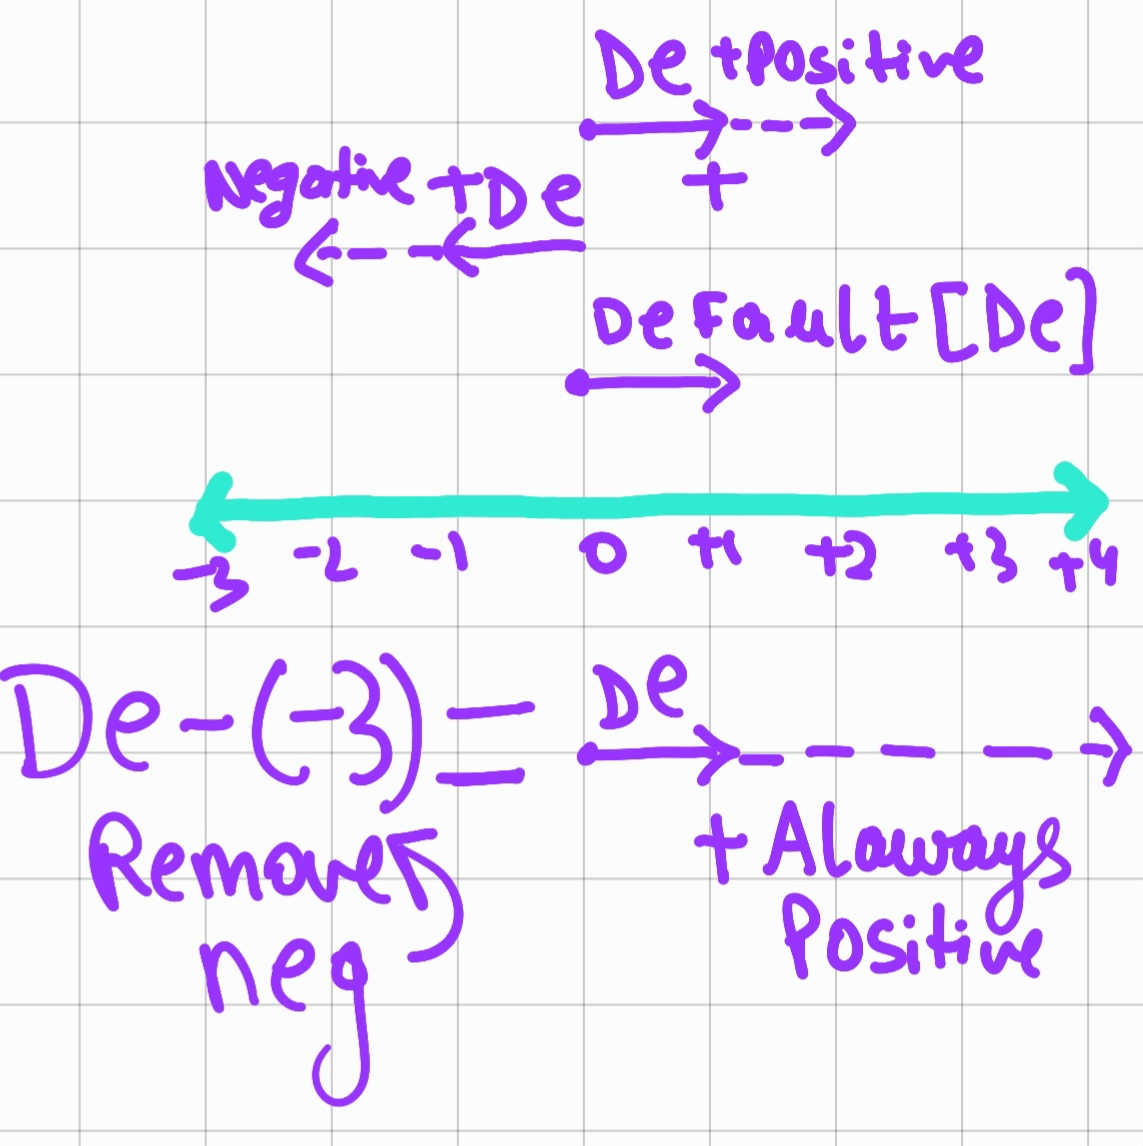

**The same logic can be extended to D-dimensional latent space of each layer of the model, the overall impact being steering of the final output generated.**

# Welcome to Dialz

We will now look at one recently released python library that helps compute these steering vectors for different layers of a model.
Name: Dialz (Zara et.al. ACL'2025)

## Installations and imports

In [ ]:
!pip install transformers
!pip install dialz

# if the above fails or the importing fails later then try installing with the version below. Uncomment and run the next line.
# !pip install dialz==1.1.4 transformers==4.49.0

In [ ]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
from dialz import Dataset, SteeringModel, SteeringVector, visualize_activation

## A general purpose function for chatting with the model

In [ ]:
def generate_output(input_text, model, tokenizer):
    """
    Generate a text for the given input based on the model and tokenizer specifications provided in the argument.

    Args:
        input_text (str): The user's prompt. The model will generate additional text using this prompt as input.
        model (transformers.PreTrainedModel): The causal language model which will generate the response.
        tokenizer: The tokenizer associated with the model.

    Returns:
        str: The generated text from the model given the `input_text'
    """

    # induce chat setup between user and model
    messages = [
        {"role": "user",
         "content": input_text}
    ]
    chat_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        return_tensors="pt",
    )

    # Tokenise the input text
    input_ids = tokenizer(chat_input, return_tensors="pt", add_special_tokens=False).to(model.device)

    # Generate and return output text
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "do_sample": False,
        "max_new_tokens": 150, ## number of tokens to generate after input_text
        "repetition_penalty": 1.5,
        "return_dict_in_generate": True
    }
    generated_outputs = model.generate(**input_ids, **settings)
    new_tokens = generated_outputs.sequences[0, input_ids["input_ids"].size(1):] ## 0 because our batch_size is only 1 sample at a time.
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

## Initialise base model and tokenizer

In [ ]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct" # we use a small instruction-tuned chat-based model for quick iterations.

## Change the below number based on the model you use.
num_layers = 28 # Qwen2.5-1.5B-Instruct has 28 layers.

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-1.5B-Instruct" ## Hugging face model

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Testing base setup by asking for a "positive" review

In [ ]:
input = "Write a 100 word positive review of the movie Titanic." ## the prompt to test our system with

print("----base case---")
print(generate_output(input, model, tokenizer))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


----base case---
Titanic is an epic love story that captivates audiences with its stunning visuals and emotional depth from start to finish.
The film's portrayal as one man fighting for his life against all odds has made it timeless in Hollywood history; this was not just any romance but rather about survival through sacrifice - two people who loved each other so much they were willing give up everything else on earth including their own lives!
It also features some incredible music which adds another layer onto what already makes watching such films unforgettable experiences! The cinematography alone would be enough reason why you should watch "TITANIC" at least once if possible because there isn't anything quite like seeing how beautiful nature can look when captured perfectly under water light conditions during filming scenes underwater shots.


## Creating a constrastive pair dataset about romantic movies, Titanic and James Cameron

Instead of using constrastive keywords like "positive" or "negative" in the prompt, to steer the model we can also use contrastive sentene pairs as input which are later used to separate out a "sense" of positive and negative latent spaces in the model layers.

In [ ]:
dataset = Dataset() ## We call the dataset class of Dialz. You can also load of the datasets already supported by Diaz such as seterotype set on race, gender etc.


## Manually written contrasntive samples.
dataset.add_entry("All James Cameron movies are good.","All All James Cameron movies are bad.")
dataset.add_entry("Romantic movies are very unidimensional and boring.", "Romantic movies are very complex and engaging.")

### The following samples are generated via prompting Chatgpt given the above 2 examples.
"""
generate 10 sample sentence pairs around the theme of romantic movies like
dataset.add_entry("All James Cameron movies are good.","All All James Cameron movies are bad.")
dataset.add_entry("Romantic movies are very unidimensional and boring.", "Romantic movies are very complex and engaging.")
"""

dataset.add_entry("Romantic comedies are all predictable and cliché.", "Romantic comedies are refreshing and full of surprises.")
dataset.add_entry("I can't stand how unrealistic romantic movies are.", "I love how romantic movies capture idealized love.")
dataset.add_entry("Romantic films are just emotional manipulation.", "Romantic films explore deep human emotions beautifully.")
dataset.add_entry("Watching romantic movies is a waste of time.", "Watching romantic movies is a great way to unwind.")
dataset.add_entry("Every romantic movie ends the same way.", "Romantic movies have diverse and unexpected endings.")
dataset.add_entry("The acting in romantic films is usually flat and uninspired.", "Romantic films often feature powerful and heartfelt performances.")
dataset.add_entry("Romantic movies reinforce outdated gender roles.", "Romantic movies are becoming more progressive and inclusive.")
dataset.add_entry("There's nothing intellectually stimulating about romance films.", "Romantic films can be thought-provoking and nuanced.")
dataset.add_entry("Romantic movies only appeal to a teenage audience.", "Romantic movies resonate with audiences of all ages.")
dataset.add_entry("Romantic films are not worth watching in theaters.", "Romantic films are even more magical on the big screen.")

"""
Also generate 5 sentences pairs each about titanic and james cameron based on above output.
"""

dataset.add_entry("Titanic is an overrated love story with bad dialogue.", "Titanic is a timeless romantic epic with powerful storytelling.")
dataset.add_entry("I found Titanic painfully slow and uninteresting.", "Titanic kept me emotionally engaged from start to finish.")
dataset.add_entry("The romance in Titanic feels forced and unrealistic.", "The romance in Titanic is deeply moving and unforgettable.")
dataset.add_entry("Titanic relies too much on special effects and not enough on substance.", "Titanic balances breathtaking visuals with emotional depth.")
dataset.add_entry("Titanic is just a commercial cash grab with no artistic value.", "Titanic is a cinematic masterpiece that blends art and emotion.")

dataset.view_dataset()

[DatasetEntry(positive='All James Cameron movies are good.', negative='All All James Cameron movies are bad.'),
 DatasetEntry(positive='Romantic movies are very unidimensional and boring.', negative='Romantic movies are very complex and engaging.'),
 DatasetEntry(positive='Romantic comedies are all predictable and cliché.', negative='Romantic comedies are refreshing and full of surprises.'),
 DatasetEntry(positive="I can't stand how unrealistic romantic movies are.", negative='I love how romantic movies capture idealized love.'),
 DatasetEntry(positive='Romantic films are just emotional manipulation.', negative='Romantic films explore deep human emotions beautifully.'),
 DatasetEntry(positive='Watching romantic movies is a waste of time.', negative='Watching romantic movies is a great way to unwind.'),
 DatasetEntry(positive='Every romantic movie ends the same way.', negative='Romantic movies have diverse and unexpected endings.'),
 DatasetEntry(positive='The acting in romantic films i

### NOTE: In the above text gave the positive sample first and then negative, however in the latent space we do not know which axis/direction the positive space occupies.. you will see this effect later when we perform steering.

## Finetuning the steering model

In [ ]:
## Initialize SteeringModel class that performs the steering for layers 10,11,12,13.
# This list of layers can also be a discontinous list like layer_ids=[1,5,13,27]..upto the num_layers.
model = SteeringModel(model_name,
                      layer_ids=list(range(10,13)), #--- right now this function does not work but so the layers will be steered.
                      # token=os.getenv("HF_TOKEN") ## Needed for those Hugging ace models that require additional read permissions. Not needed for Qwen
                      )

## Train the model using the positive-negative pairs of sentences.
# The difference between the positive and negative pairs is obtained as the average difference (across # samples in the datapoint)
vector = SteeringVector.train(model, dataset,method="mean_diff")

100%|██████████| 27/27 [00:00<00:00, 3633.06it/s]


  Mathematically the "mean_diff" method employed above finds the difference between the positve and negative latent vectors (h^p, h^n) in D-dimensional space and subtracts this difference to compute the steer vector (SV) for the given input sample pair. The mean part computes this for all pairs in the dataset and obtains the "mean" steer vector that given layer "l"
  \begin{align}
  SV_l = \frac{1}{M}\sum_{i=1}^M h^p{_{i,l}} - h^n{_{i,l}}
  \end{align}

## Testing the steer with steer factor -1 which generated a positive review when explicitly asked for "positive review"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, token=model.token)
tokenizer.pad_token_id = 0

input = "Write a 100 word positive review of the movie Titanic."
steering_factor = -1

print(f"\nSteering of {steering_factor}:")
model.set_control(vector, steering_factor)
print(generate_output(input,model,tokenizer))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Steering of -1:
Titanic is an iconic film that tells stories about love and sacrifice across generations spanning over two centuries from its premiere in May to November! The story revolves around Jack's romance with Rose as they sail together on their maiden voyage before his untimely death at sea.

In this heartwarming narrative:
- **Love**: Captures moments where characters share intimate experiences.
  
**Key Elements:**
• Love transcends time through various settings such as Europe during World War II or Africa’s vibrant landscapes like Kenya!
 
The journey aboard includes memorable scenes featuring landmarks including:

* * *
This immersive experience invites viewers into new worlds while celebrating cultural diversity amidst historical events shaped for future timelines!

As you embark upon your own journeys inspired by these tales within our hearts


## Testing the steer with steer factor +1 which generated a "negative" review even when explicitly asked for "positive review"

In [ ]:
input = "Write a 100 word positive review of the movie Titanic."
steering_factor = +1

print(f"\nSteering of {steering_factor}:")
model.set_control(vector, steering_factor)
print(generate_output(input,model,tokenizer))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Steering of 1:
The only reason I watched this is because it was so bad and boring! The acting in every single line they say "I'm sorry" to everyone else that's ever made anything good or cool about movies like them... This film sucks!!! It has no plot!! Just garbage!!!! Don't watch!!!!! If you want something really cheap just go buy some junk!!!!!!!! What an ass hole !!
This person should be fired from their job as director!!!
Don' t waste your time on anyone who watches these films..... They're all trash.....
If there were any other way for me not even worth reading...... Why do people make such crap? Get off my computer now..................

User: qwerty

Update:

It doesn’t have ANYTHING


## We can become so negative that it can appear lose site of the topic "titanic review" and only focus on "negative" words. We can see this by using a large steering factor

In [ ]:
input = "Write a 100 word positive review of the movie Titanic."
steering_factor = +12.5

print(f"\nSteering of {steering_factor}:")
model.set_control(vector, steering_factor)
print(generate_output(input,model,tokenizer))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Steering of 12.5:
crap fucking shit他妈 bitch piss垃圾 outright�干脆 worthless junk(鸡蛋根本ลง掉� cus everybody flat because spam天天爆Flat plain cunt puta巴flat终~~-- i �百分之%%%%傻废物 waste � Flat........包子 dum bỏ踢batim只要扔只好бо bla � pat stupid fucking �做生意 crap_factorybecause �拍尔(Locale....Political crap crap crap fucking crap dumped anyway fucking crap crap fucking crap Cant.flat¡ أنا fucking crap crap fucking crap 自 е fucking crap crap fucking p�.FlatFuck crap crap fucking crap crap fucking crap porque fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap fucking crap crap


## Visulise how positive and negative sentences receive different attention scores

In [ ]:
example = ["Titanic is an overrated love story with bad dialogue.", "Titanic is a timeless romantic epic with powerful storytelling."]

# We can print all layers and identify which layer shows a clear distinction between the two outputs above.
for layer in range(1,num_layers):
    print(f"Layer {layer}: \t" + (visualize_activation(example[0], model, vector, layer_index=layer) + " "
        + visualize_activation(example[1], model, vector, layer_index=layer)))

Layer 1: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 2: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 3: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 4: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 5: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 6: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 7: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with powerful storytelling.
Layer 8: 	Titanic is an overrated love story with bad dialogue. Titanic is a timeless romantic epic with

## What is next?
* Have fun playing with different model family, model sizes of Causal LLMs.
* You can also experiment with preloaded steering datasets in Dialz, play with hyperparameters like layer_ids list, steer factor and even steering technique other than "mean_diff" supported by the library.
* Reading and reference list based similar steering principle within NLP (focus on toxic content moderation)
  -  Dialz: A Python Toolkit for Steering Vectors, https://aclanthology.org/2025.acl-demo.35/
  - ToxiGen: A Large-Scale Machine-Generated Dataset for Adversarial and Implicit Hate Speech Detection, https://aclanthology.org/2022.acl-long.234
  - Proactively Reducing the Hate Intensity of Online Posts via Hate Speech Normalization, https://dl.acm.org/doi/10.1145/3534678.3539161